# Classifying Heart Disease using Logistic Regression

In this project, we will be using logistic regression modelling to try to predict whether a patient has heart disease. We will be using a [Heart Disease Data Set](https://archive.ics.uci.edu/dataset/45/heart+disease) from UCI Machine Learning Repository. We will be using the Cleveland subset, which the data set description says is standard practice for Machine Learning.

The goal is to create a model that can bulk analyse patient data and flag patients that suffer from Heart Disease. If these patients were not already classified as having heart disease, they could be sent to a clinician.

For this project, we are focussing on binary classification. The original data set used multi-class classification, so the data set has already been partially cleaned to binary.

The features in the partially cleaned data set are:

* `age`: age in years
* `sex`: sex (1 = male; 0 = female)
* `cp`: chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
* `trestbps`: resting blood pressure (in mm Hg on admission to the hospital)
* `chol`: serum cholesterol in mg/dl
* `fbs`: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
* `restecg`: resting electrocardiographic results (0 = normal; 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV); 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
* `thalach`: maximum heart rate achieved
* `exang`: exercise induced angina (1 = yes; 0 = no)
* `oldpeak`: ST depression induced by exercise relative to rest
* `slope`: the slope of the peak exercise ST segment (0 = upsloping; 1 = flat; 2 = downsloping)
* `ca`: number of major vessels (0-3) coloured by fluoroscopy
* `thal`: 3 = normal; 6 = fixed defect; 7 = reversible defect
* `present`: diagnosis of heart disease (angiographic disease status) (0 = no; 1 = yes)

We'll begin by importing our libraries and reading in the data set. Then we'll take perform some exploratory data analysis.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay



In [2]:
heart = pd.read_csv('heart_disease.csv')
heart.head()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,present
0,1,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,2,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,3,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,4,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,5,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


## Exploratory Data Analysis

Let's take a first look at the data.

In [3]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  303 non-null    int64  
 1   age         303 non-null    int64  
 2   sex         303 non-null    int64  
 3   cp          303 non-null    int64  
 4   trestbps    303 non-null    int64  
 5   chol        303 non-null    int64  
 6   fbs         303 non-null    int64  
 7   restecg     303 non-null    int64  
 8   thalach     303 non-null    int64  
 9   exang       303 non-null    int64  
 10  oldpeak     303 non-null    float64
 11  slope       303 non-null    int64  
 12  ca          303 non-null    object 
 13  thal        303 non-null    object 
 14  present     303 non-null    int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 35.6+ KB


No columns contain null values, which is a good sign. The majority of the data is numerical, with only  `ca` and `thal` being categorical.

As a reminder:
* `ca`: number of major vessels (0-3) coloured by fluoroscopy
* `thal`: 3 = normal; 6 = fixed defect; 7 = reversible defect

`ca` can be converted over to `int`. We could one-hot encode the `thal` column, but we'll leave that for now. Later, we'll graph its relationship to `present` and decide how to deal with it.

In [4]:
heart['ca'].value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: ca, dtype: int64

4 rows have `ca` as `?`. Since it's only a few rows, we'll drop them rather than trying to estimate their value. Then we'll convert `ca` to `float`.

In [5]:
# Drops questionable rows
heart = heart[heart['ca'] != '?']

# Convert ca to float
heart['ca'] = heart['ca'].astype('float')
heart['ca'].value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
Name: ca, dtype: int64

That looks better. Next we'll have a look at max/min values.

In [6]:
heart.describe()

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,present
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,150.852843,54.528428,0.675585,3.160535,131.668896,247.100334,0.147157,0.996656,149.505017,0.327759,1.051839,1.602007,0.672241,0.461538
std,87.365535,9.020950,0.468941,0.962893,17.705668,51.914779,0.354856,0.994948,22.954927,0.470183,1.163809,0.617526,0.937438,0.499354
min,1.000000,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,75.500000,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,150.000000,56.000000,1.000000,3.000000,130.000000,242.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,0.000000
75%,226.500000,61.000000,1.000000,4.000000,140.000000,275.500000,0.000000,2.000000,165.500000,1.000000,1.600000,2.000000,1.000000,1.000000
max,302.000000,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


They all seem reasonable.

## Choosing predictors

Before we investigate correlations, lets loop back to `thal` and see how it relates to `present`.

In [7]:
heart['thal'].value_counts()

3.0    164
7.0    115
6.0     18
?        2
Name: thal, dtype: int64

Again, we have a number of `?`. Let's drop them. After that we'll plot `thal` vs `present`, stratified by `sex`.

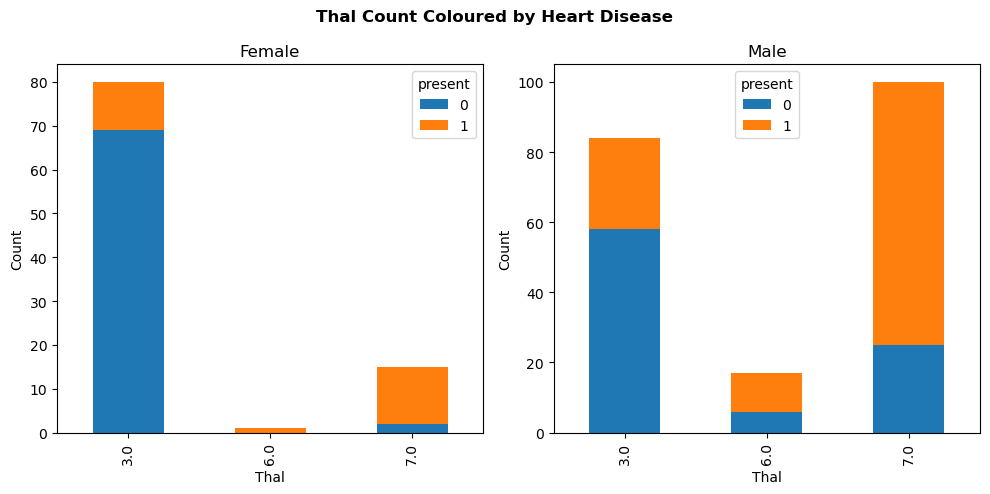

In [8]:
# Drops questionable rows
heart = heart[heart['thal'] != '?']
# Creates lists for sex
sex = [0, 1]
sex_name = ['Female', 'Male']

# Creates a figure
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle('Thal Count Coloured by Heart Disease', fontweight='bold')

for i, sex in enumerate(sex):
    data = heart[heart['sex'] == sex]

    # Plots `thal` vs `present` using pd.crosstab
    plot = pd.crosstab(data['thal'], data['present'])
    plot.plot(kind='bar', stacked=True, ax=ax[i])
    ax[i].set_title(sex_name[i])
    ax[i].set_xlabel('Thal')
    ax[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


Although thal represents a categorical variable, we can see a clear increase in ratio of heart disease being present increases as we move from `3` to `7`. As such, we're going to treat it as an ordinal variable, and remap the values to 0, 1, and 2, respectively.

In [9]:
# Converts thal to 0,1,2 using map
heart['thal'] = heart['thal'].map({'3.0': 0, '6.0': 1, '7.0': 2})
heart['thal'] = heart['thal'].astype(int)
heart['thal'].value_counts()

0    164
2    115
1     18
Name: thal, dtype: int64

### Plotting correlation

Now we've converted `thal` to a numerical type, let's plot a heatmap of correlation. We're interested in the correlations against `present`.

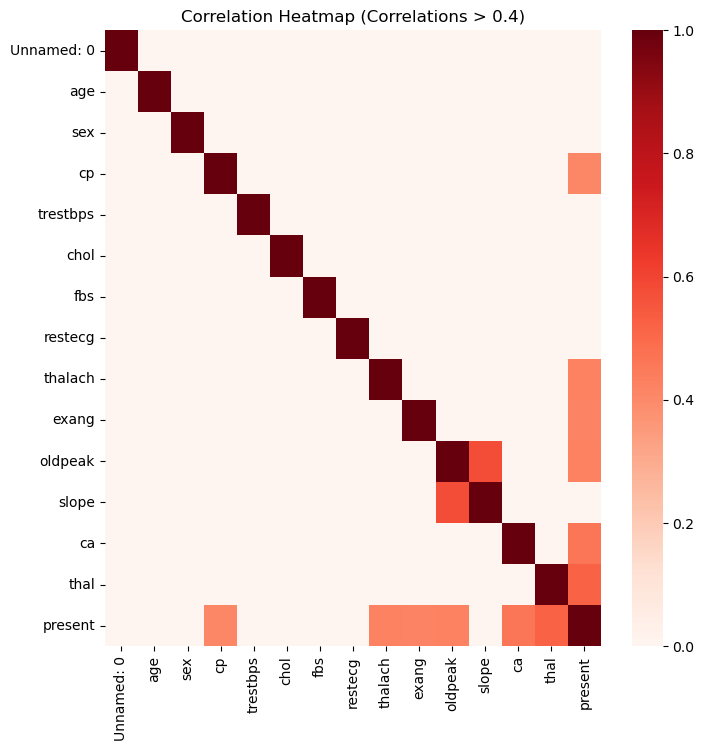

In [10]:
# Gets correlations and finds correlations > 0.4
corr = heart.corr().abs()
high_corr = corr[corr > 0.4].fillna(0)

# Set up the matplotlib figure
plt.figure(figsize=(8, 8))

# Draw the heatmap
sns.heatmap(high_corr, cmap='Reds')
plt.title('Correlation Heatmap (Correlations > 0.4)')
plt.show()


As we'd expected from our previous plot, `thal` shows a strong correlation with `present`. In fact, it's the highest correlated feature. Interestingly, although `sex` had a large impact on our `thal` plot, it doesn't seem to be highly correlated with `present`.

Let's find the full correlation figures with `present`.

In [11]:
# Gets correlations with present
corr['present'].sort_values(ascending=False)

present       1.000000
thal          0.520516
ca            0.463189
oldpeak       0.424052
thalach       0.423817
exang         0.421355
cp            0.408945
slope         0.333049
sex           0.278467
age           0.227075
restecg       0.166343
trestbps      0.153490
chol          0.080285
Unnamed: 0    0.051891
fbs           0.003167
Name: present, dtype: float64

Above, we can see `sex` is only a middling predictor, far below `thal`. We'll move forward with the top 5 predictors, which all have a correlation greater than 0.42.

In [12]:
# Drops present
corr = corr.drop(['present'])

predictors = corr['present'][corr['present'] > 0.42].index
predictors

Index(['thalach', 'exang', 'oldpeak', 'ca', 'thal'], dtype='object')

## Building the Model

Now we've chosen our predictors, we can build our model. We'll start by splitting the data into training and testing sets. We'll use the [formula](https://onlinelibrary.wiley.com/action/showCitFormats?doi=10.1002%2Fsam.11583) presented in [Statistical Analysis and Data Mining: The ASA Data Science Journal](https://onlinelibrary.wiley.com/journal/19321872) to determine the size of our training and testing sets.

In [13]:
# Splits the data
X = heart[predictors]
y = heart['present']

# Determines test size
p = len(predictors)
test_size = 1 / (np.sqrt(p) + 1)
print(f'{test_size=:.3f}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

test_size=0.309


Let's check the ratios of `present` in our training and testing sets.

In [14]:
y_train.value_counts(normalize=True)

0    0.541463
1    0.458537
Name: present, dtype: float64

In [15]:
y_test.value_counts(normalize=True)

0    0.532609
1    0.467391
Name: present, dtype: float64

They're pretty similar, so we can move on.

Next, we'll build the model and see how accurate our model is on the training set.

In [16]:
model = LogisticRegression()
model.fit(X_train, y_train)

training_accuracy = model.score(X_train, y_train)
training_accuracy

0.824390243902439

Our initial accuracy is 0.83, which is ok. However, that just gives us a general prediction and is likely to be optimistic as it's our training accuracy. Let's dig a bit deeper into how our model is doing.

## Evaluating Model Performance

We are more interested in how many false negatives there are. Since a patient classified as having heart disease will be sent to a doctor, false positives will be caught by the clinician. However, if there are high numbers of false negatives, this means patients with heart disease aren't being seen, which could lead to dangerous, or even fatal, outcomes.

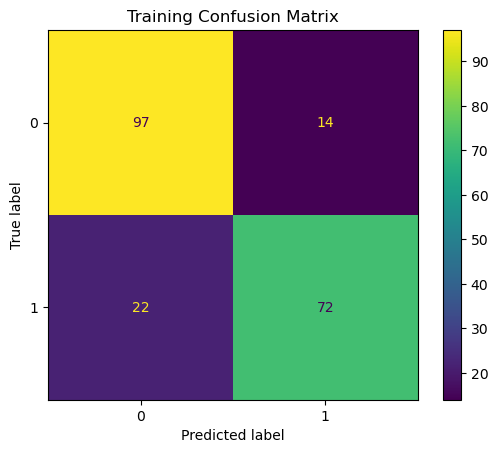

Training Sensitivity: 0.766
Training Specificity: 0.874


In [17]:
def plot_confusion_matrix(model, X, y, stage=None):
    ''' Plots a confusion matrix for a given model and data.'''
    y_pred = model.predict(X)

    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f'{stage} Confusion Matrix')
    plt.show()

    # Calculate TP, TN, FP, and FN
    TN, FP, FN, TP = cm.ravel()

    # Calculate sensitivity and specificity
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    print(f"{stage} Sensitivity: {sensitivity:.3f}")
    print(f"{stage} Specificity: {specificity:.3f}")


plot_confusion_matrix(model, X_train, y_train, stage='Training')

Here we can see our model does a reasonable job, and also that there are higher count of false negatives than there are false positives. 

Rather than just using counts, we've also calculated the sensitivity (a measure of true positives vs false negatives) and specificity (a measure of true negatives vs false positives).

We can see that our model is ~10% better at predicting negatives than positives. What this means in practice is that there will be fewer false negatives than false positives, which is exactly what we wanted.

### Evaluating Coefficients

Next, lets look at the coefficients of our model. We initially get them in Log Odds. We'll convert these back to Odds Ratio and display both in a DataFrame.

In [18]:
# Get coefficients
coefs = model.coef_

# Transpose coefs array
coefs = coefs.T

# Create DataFrame with coefficients and predictor names
df_coefs = pd.DataFrame(coefs, index=predictors, columns=['Log Odds']).sort_values(by='Log Odds', ascending=False)
df_coefs['Odds Ratio'] = np.exp(df_coefs['Log Odds'])

df_coefs


,Log Odds,Odds Ratio
ca,1.034036,2.812394
thal,0.860341,2.363967
exang,0.776374,2.173576
oldpeak,0.422240,1.525374
thalach,-0.018100,0.982063


These are the increase in odds of a binary switch in our target variable, controlling for all other variables. Or in plain language, its the change in odds for having heart disease for an increase in that predictor, with all other predictors staying the same. The higher the odds, the more likely we are to have heart disease.

For a reminder, here's the information on our predictors.
* `ca`: number of major vessels (0-3) coloured by fluoroscopy
* `thal`: 3 = normal; 6 = fixed defect; 7 = reversible defect (mapped to an ordinal variable as 0-2)
* `exang`: exercise induced angina (1 = yes; 0 = no)
* `oldpeak`: ST depression induced by exercise relative to rest
* `thalach`: maximum heart rate achieved

Most of them have high odds ratio, meaning if they're present, they're more likely to have heart disease. This makes sense given the nature of our predictors.

`thalach` has an odds ratio below 1, which means increasing `thalach` *decreases* the odds of having heart disease. Again, looking at what this predictor measures, this makes sense. In general, healthier hearts can hit higher max heart rates than unhealthy ones. Although the ratio is closer to 1, the range of values for `thalach` are much wider than our other variables (71-202 BMP) with every BPM increasing or decreasing the odds of having heart disease. 

## Final Model Evaluation

Now we've dug further into how the model's worked. Let's see how it performs with our test set.

In [19]:
test_accuracy = model.score(X_test, y_test)

print(f'Training Accuracy: {training_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

Training Accuracy: 0.824
Test Accuracy: 0.870


Our accuracy is higher than in training. We expect our training accuracy to be optimistic, so that's a bit of a surprise.

Before we get too excited, lets look at our confusion matrix, as we have identified false negatives as the most important measure in our case.

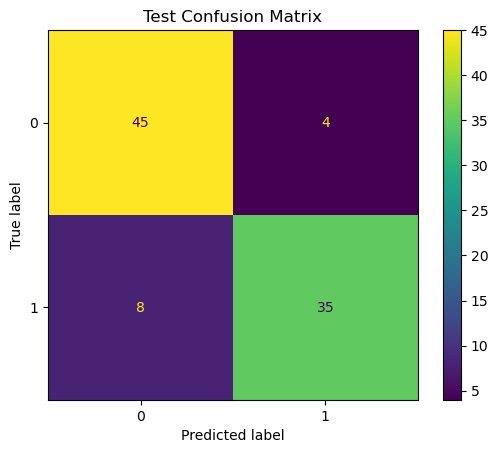

Test Sensitivity: 0.814
Test Specificity: 0.918


In [20]:
plot_confusion_matrix(model, X_test, y_test, stage='Test')

Sensitivity and specificity are also improved, which is brilliant. And, more importantly, our model still predicts negative diagnoses the best. As we said before, false positives are less of an issue as these patients would be directed to a clinician who could spot our mistake.

As it stands, our model is accurate 91.8% of the time when predicting a patient does not have heart disease. That may not be high enough to replace a trained clinician, but it could be used to bulk analyze patient data to prioritise care. In this usage, it would work very well, assuming patients had the right data available.

One next step could be to talk to a clinician to see which features are widely measured, and build a model using these. This would give us the widest applicability.

Or, if we wanted to build a more accurate model, we could investigate any combination of the following:
* Using different predictors
* Using a different number of predictors
* Using different models
* Scaling our data
* Using different training and testing sizes